# Microgrid in Japan - Scenario production/consumption prediction based on real data

https://www.nature.com/articles/sdata201920?fbclid=IwAR3qOLHs0Ra5HNiXr3GZt5BdkG56WryLDnubRFd21lil12LAQXJlzb0tTT8

In [1]:
import csv
from io import TextIOWrapper
from zipfile import ZipFile
import pandas as pd
import os
import glob
import multiprocessing as mp
import seaborn as sns

In [2]:
"""
Time series prediction framework is based on HCrystal Ball library (https://github.com/heidelbergcement/hcrystalball).
"""
from datetime import datetime as dt
tags=[]
mape_baseline=[]
mape_algoritmo=[]
mae_baseline=[]
mae_algoritmo=[]
mape_percentiles=[]
mae_percentiles=[]
mape_med=[]
mae_med=[]
top10erro_teste=[]
teste_lista=[]

algoritmos_vencedores=[]

import sys  
sys.path.insert(0, '.')
from training_utils import *

from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, median_absolute_error
import datetime
import numpy as np
import click
import mlflow
import pandas as pd


from pprint import pprint
import logging
import tempfile
import os
import glob


logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

/usr/local/lib64/python3.6/site-packages/numba/core/ir.py:29: DeprecationWarning: invalid escape sequence \s
  _defmatcher = re.compile('def\s+(\w+)\(.*')
/usr/local/lib64/python3.6/site-packages/numba/core/ir.py:1573: DeprecationWarning: invalid escape sequence \l
  ['  {}\l'.format(x) for x in label.splitlines()],
/usr/local/lib64/python3.6/site-packages/numba/core/ir.py:1575: DeprecationWarning: invalid escape sequence \l
  label = "block {}\l".format(k) + label
/usr/local/lib64/python3.6/site-packages/numba/core/ir.py:1578: DeprecationWarning: invalid escape sequence \l
  label = "{}\l".format(k)
/usr/local/lib64/python3.6/site-packages/numba/core/codegen.py:236: DeprecationWarning: invalid escape sequence \!
  ll_raise = re.compile("ret i32.*\!ret_is_raise.*")
/usr/local/lib64/python3.6/site-packages/numba/core/annotations/type_annotations.py:275: DeprecationWarning: invalid escape sequence \s
  re_longest_white_prefix = re.compile('^\s*')
/usr/local/lib64/python3.6/site-packages/

## 0. Season definition

In [3]:
# Japan is Northern Hemisphere
start_month = {'winter' : 12, 'spring': 3, 'summer': 6, 'autumn': 9}
end_month = {'winter' : 2, 'spring': 5, 'summer': 8, 'autumn' : 11}

In [4]:
# Percentile 10%
def q10(x):
    return x.quantile(0.1)

# Percentile 90%
def q90(x):
    return x.quantile(0.9)

In [5]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 6]

## 1. Load pre-processed dataset files containing power values with 5 min resolution

In [6]:
def load_dataset(path):
    df = pd.read_csv(path).set_index('timestamp')
    return df

In [7]:
def parallelize_dataframe_processing(file_list, func, n_cores=16):
    pool = mp.Pool(n_cores)
    df = pd.concat(pool.map(func, file_list))
    pool.close()
    pool.join()
    return df

In [8]:
dataset_treated_dir = os.path.join(os.getcwd(), 'scenarios')
print("dataset_treated_dir: " + dataset_treated_dir)
file_list = glob.glob(os.path.join(str(dataset_treated_dir), '*_5m_*.csv.gz'))
df = parallelize_dataframe_processing(file_list, load_dataset)
df.head(4)

dataset_treated_dir: /projetos/CZT0/doutorado_files/microgrid/scenarios


,Active power of the battery (kW),Direct voltage of the battery (V),Direct current of the battery (A),Voltage of purchased electricity at the receiving end (V),Active power of purchased electricity at the receiving end (kW),Total active power generation by all four solar arrays (kW),Active battery power command value (kW),State of charge of the battery (%),Building_Consumption,scenario_name,Unnamed: 13,Unnamed: 14
timestamp,,,,,,,,,,,,
2015-04-25 00:00:00,-0.88400,344.981073,-0.531250,6528.5475,465.308003,0.0,0.0,95.0,-465.308003,2015-04-25,NaN,NaN
2015-04-25 00:05:00,-0.86725,344.857349,-0.402083,6583.8375,474.532002,0.0,0.0,95.0,-474.532002,2015-04-25,NaN,NaN
2015-04-25 00:10:00,-0.87050,344.827050,-0.430208,6589.5450,486.660001,0.0,0.0,95.0,-486.660001,2015-04-25,NaN,NaN
2015-04-25 00:15:00,-0.86675,344.745829,-0.442708,6560.5050,474.939998,0.0,0.0,95.0,-474.939998,2015-04-25,NaN,NaN


In [9]:
df = df.drop(columns=['Unnamed: 13', 'Unnamed: 14'])
df['Building_Consumption'] *= -1
df.index = pd.DatetimeIndex(df.index)
df.loc[df['Total active power generation by all four solar arrays (kW)'] < 0, 'Total active power generation by all four solar arrays (kW)'] = 0
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 348480 entries, 2015-04-25 00:00:00 to 2018-03-24 23:55:00
Data columns (total 10 columns):
 #   Column                                                           Non-Null Count   Dtype  
---  ------                                                           --------------   -----  
 0   Active power of the battery (kW)                                 347988 non-null  float64
 1   Direct voltage of the battery (V)                                347853 non-null  float64
 2   Direct current of the battery (A)                                341950 non-null  float64
 3   Voltage of purchased electricity at the receiving end (V)        347988 non-null  float64
 4   Active power of purchased electricity at the receiving end (kW)  347988 non-null  float64
 5   Total active power generation by all four solar arrays (kW)      347988 non-null  float64
 6   Active battery power command value (kW)                          347988 non-null  float64


In [10]:
# Remove unrelated columns from dataframe
baseline_original = df.drop(columns=['Active power of the battery (kW)', 'Direct voltage of the battery (V)', 'Direct current of the battery (A)',
                 'Voltage of purchased electricity at the receiving end (V)', 'Active power of purchased electricity at the receiving end (kW)',
                 'Active battery power command value (kW)', 'State of charge of the battery (%)', 'scenario_name'])
baseline_original.head(2)

,Total active power generation by all four solar arrays (kW),Building_Consumption
timestamp,,
2015-04-25 00:00:00,0.0,465.308003
2015-04-25 00:05:00,0.0,474.532002


## 2. Set-up prediction parameters

### 2.1. List of target columns in prediction

In [11]:
tag_list = ['Building_Consumption', 'Total active power generation by all four solar arrays (kW)']

In [12]:
resultados = pd.DataFrame()
tag = tag_list[0]
target_col=tag
baseline=baseline_original[target_col]

baseline=baseline.to_frame()
for col in baseline.columns:
    #print(col)
    baseline[col] = baseline[col].astype('float32')
base_col_list = baseline.columns.tolist()
# Substituindo valores NaN por zero
baseline = baseline.fillna(0)

In [13]:
baseline['data']=baseline.index

baseline['data']=pd.DatetimeIndex(baseline['data'])
baseline.set_index('data',inplace=True)
baseline

,Building_Consumption
data,
2015-04-25 00:00:00,465.308014
2015-04-25 00:05:00,474.532013
2015-04-25 00:10:00,486.660004
2015-04-25 00:15:00,474.940002
2015-04-25 00:20:00,472.747986
...,...
2018-03-24 23:35:00,532.375977
2018-03-24 23:40:00,546.096008
2018-03-24 23:45:00,550.984009


### Histogram of target value

<AxesSubplot:>

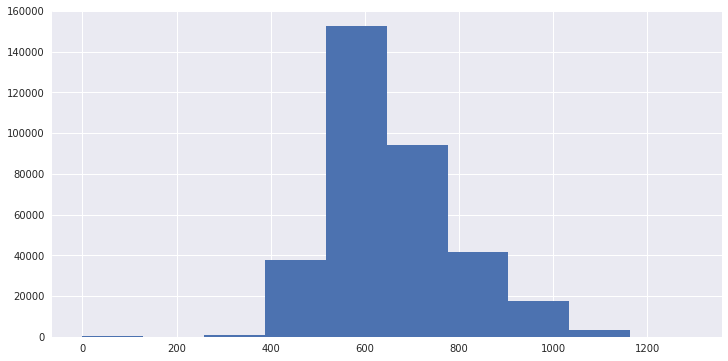

In [14]:
baseline[target_col].hist()

### Brute values of time series

<AxesSubplot:xlabel='data'>

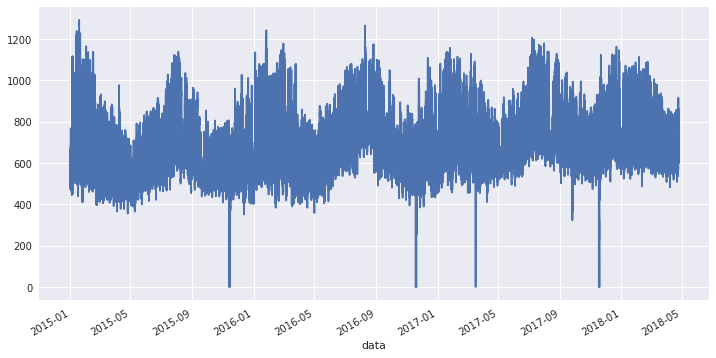

In [15]:
baseline[target_col].plot()

### 2.2. Generating intraday features

In [16]:
first_mean=baseline.between_time('07:00:00','12:00:00').groupby(pd.Grouper(freq='D')).mean()
#first_mean.index = first_mean.index.tz_localize(None)
first_mean=first_mean.resample('1D').mean()
#print(first_mean)
#first_mean=first_mean.to_frame()
first_mean.columns=['first_mean']
first_mean

,first_mean
data,
2015-01-01,596.477356
2015-01-02,616.010193
2015-01-03,641.807739
2015-01-04,638.959106
2015-01-05,825.451965
...,...
2018-04-20,752.891296
2018-04-21,605.715942
2018-04-22,738.246826


In [17]:
first_max=baseline.between_time('07:00:00','12:00:00').groupby(pd.Grouper(freq='D')).max()
#first_max.index = first_max.index.tz_localize(None)
first_max=first_max.resample('1D').max()
#first_max=first_max.to_frame()
first_max.columns=['first_max']
first_max

,first_max
data,
2015-01-01,640.854065
2015-01-02,662.942505
2015-01-03,701.495300
2015-01-04,740.672852
2015-01-05,1112.978027
...,...
2018-04-20,857.656433
2018-04-21,635.242859
2018-04-22,835.408447


In [18]:
percentile_85=baseline.between_time('07:00:00','12:00:00').groupby(pd.Grouper(freq='D')).quantile(0.85)
#percentile_85.index = percentile_85.index.tz_localize(None)
percentile_85=percentile_85.resample('1D').mean()
#percentile_85=percentile_85.to_frame()
percentile_85.columns=['percentile_85']
percentile_85

,percentile_85
data,
2015-01-01,623.943970
2015-01-02,644.266968
2015-01-03,665.963989
2015-01-04,678.243286
2015-01-05,1030.263794
...,...
2018-04-20,806.552673
2018-04-21,626.060669
2018-04-22,807.200745


In [19]:
first_mean_nz=baseline.between_time('07:00:00','12:00:00')[baseline.between_time('07:00:00','12:00:00')!=0].groupby(pd.Grouper(freq='D')).mean()
#first_mean_nz.index = first_mean_nz.index.tz_localize(None)
first_mean_nz=first_mean_nz.resample('1D').mean()
#first_mean_nz=first_mean_nz.to_frame()
first_mean_nz.columns=['first_mean_nz']
first_mean_nz

,first_mean_nz
data,
2015-01-01,596.477356
2015-01-02,616.010193
2015-01-03,641.807739
2015-01-04,638.959106
2015-01-05,825.451965
...,...
2018-04-20,752.891296
2018-04-21,605.715942
2018-04-22,738.246826


In [20]:
dtf_resample = baseline.resample('1D').mean()
dtf=dtf_resample.join(first_mean)
dtf=dtf.join(first_max)
dtf=dtf.join(first_mean_nz)
dtf=dtf.join(percentile_85)
dtf

,Building_Consumption,first_mean,first_max,first_mean_nz,percentile_85
data,,,,,
2015-01-01,593.660950,596.477356,640.854065,596.477356,623.943970
2015-01-02,610.541809,616.010193,662.942505,616.010193,644.266968
2015-01-03,614.025635,641.807739,701.495300,641.807739,665.963989
2015-01-04,583.476318,638.959106,740.672852,638.959106,678.243286
2015-01-05,682.978760,825.451965,1112.978027,825.451965,1030.263794
...,...,...,...,...,...
2018-04-20,677.833069,752.891296,857.656433,752.891296,806.552673
2018-04-21,592.427490,605.715942,635.242859,605.715942,626.060669
2018-04-22,667.208984,738.246826,835.408447,738.246826,807.200745


In [21]:
dtf=dtf.fillna(0)
dtf

,Building_Consumption,first_mean,first_max,first_mean_nz,percentile_85
data,,,,,
2015-01-01,593.660950,596.477356,640.854065,596.477356,623.943970
2015-01-02,610.541809,616.010193,662.942505,616.010193,644.266968
2015-01-03,614.025635,641.807739,701.495300,641.807739,665.963989
2015-01-04,583.476318,638.959106,740.672852,638.959106,678.243286
2015-01-05,682.978760,825.451965,1112.978027,825.451965,1030.263794
...,...,...,...,...,...
2018-04-20,677.833069,752.891296,857.656433,752.891296,806.552673
2018-04-21,592.427490,605.715942,635.242859,605.715942,626.060669
2018-04-22,667.208984,738.246826,835.408447,738.246826,807.200745


### 2.3. Comparison (correlation) between intraday features and target values

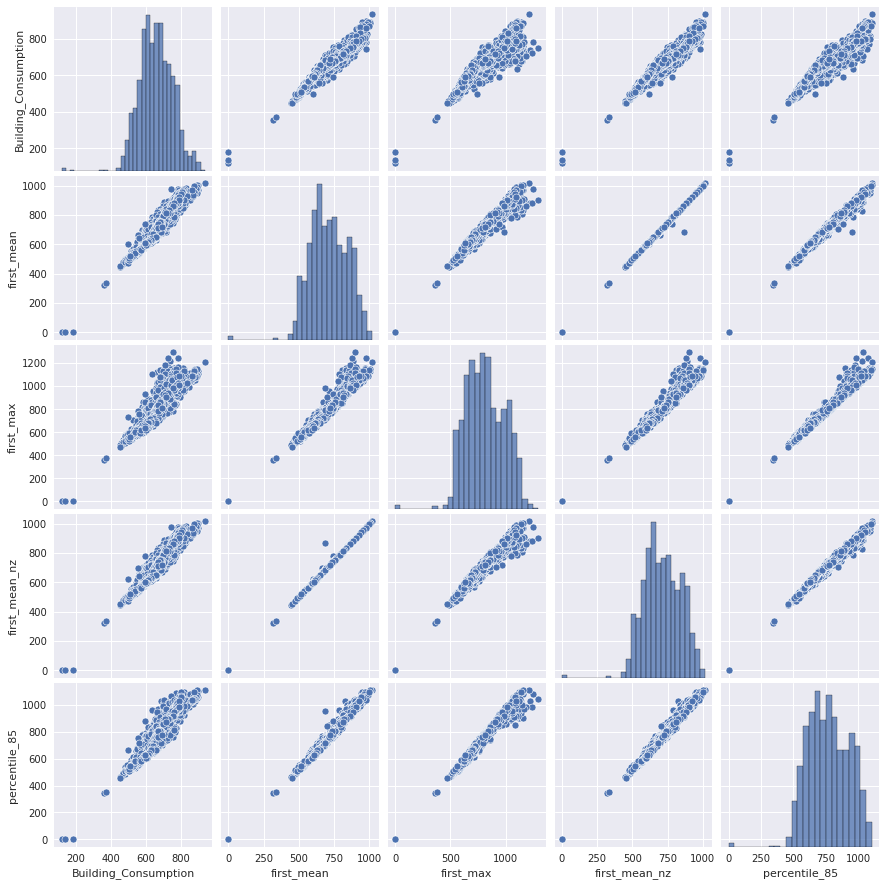

In [22]:
sns.pairplot(dtf)

### Regression - Average from 07 to 12h and target

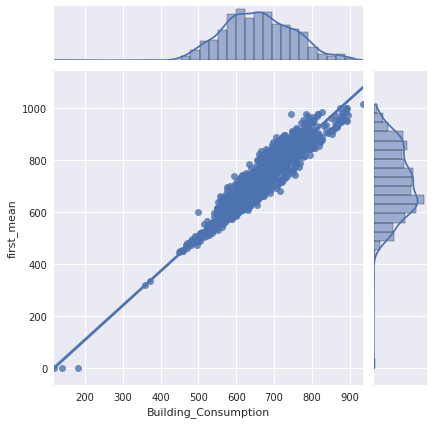

In [23]:
sns.jointplot(data=dtf,x=target_col,y='first_mean',kind='reg')

### Regression - Maximum value from 07 to 12h and target

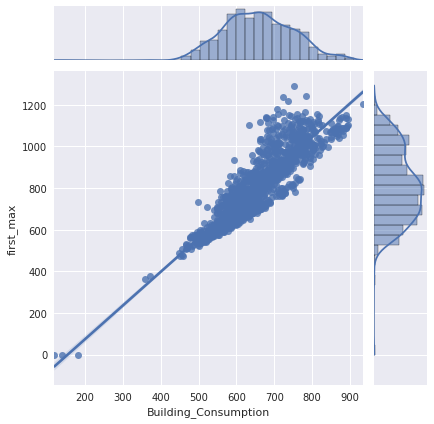

In [24]:
sns.jointplot(data=dtf,x=target_col,y='first_max',kind='reg')

In [25]:
dtf.corr()

,Building_Consumption,first_mean,first_max,first_mean_nz,percentile_85
Building_Consumption,1.000000,0.951617,0.892530,0.951249,0.926161
first_mean,0.951617,1.000000,0.972706,0.999098,0.990911
first_max,0.892530,0.972706,1.000000,0.973479,0.984628
first_mean_nz,0.951249,0.999098,0.973479,1.000000,0.991826
percentile_85,0.926161,0.990911,0.984628,0.991826,1.000000


### Histogram of the difference between Intra and Inter Average values

<AxesSubplot:>

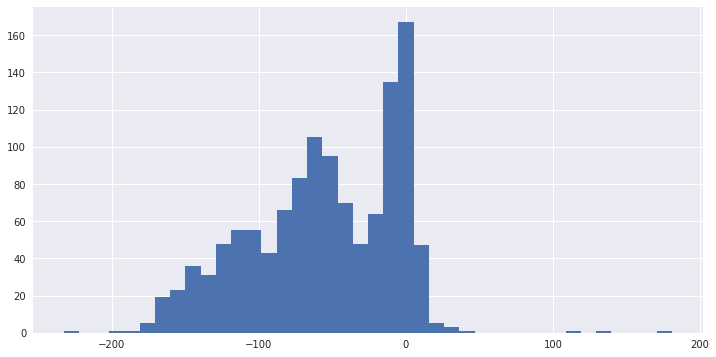

In [26]:
dtf['Dif. Avg. Intra and Inter']=dtf[target_col]-dtf['first_mean']
dtf['Dif. Avg. Intra and Inter'].hist(bins=40)

### 2.4. Generate additional features using HCrystalBall

In [27]:
X, y = dtf.drop(columns=dtf.columns.tolist()), dtf[target_col]
exog_model_pipeline = Pipeline([
    ('holidays_jp', HolidayTransformer(country_code='JP')), # , days_before=2, days_after=1, bridge_days=True)),
    # ('sklearns_native_transformers', sklearns_native_transformers),
    ('seasonality', SeasonalityTransformer(auto=True, freq='D')),
    #('model', best_model)
])


exog_features = exog_model_pipeline.fit(X, y).transform(X)
print('Exog features: \n', exog_features.tail(12))


weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)




Exog features: 
            _holiday_JP  _Friday  _Monday  _Saturday  _Sunday  _Thursday  \
data                                                                      
2018-04-13                    1        0          0        0          0   
2018-04-14                    0        0          1        0          0   
2018-04-15                    0        0          0        1          0   
2018-04-16                    0        1          0        0          0   
2018-04-17                    0        0          0        0          0   
2018-04-18                    0        0          0        0          0   
2018-04-19                    0        0          0        0          1   
2018-04-20                    1        0          0        0          0   
2018-04-21                    0        0          1        0          0   
2018-04-22                    0        0          0        1          0   
2018-04-23                    0        1          0        0          0   
2018-04-

In [28]:
dtf = dtf.join(exog_features)

add_features=False
if add_features:
    df_features,df_rolled=adiciona_features_tsfresh(dtf=dtf,target_col=target_col,window_size=None)
    #total_features=exog_features.columns.tolist()+df_features.columns.tolist()
else:
    total_features=exog_features.columns.tolist()
periods=92  # 92 days
split_date=dtf.index[-periods]
dtf_train = dtf[:split_date]
dtf_test = dtf[split_date:]
print('Train Dataset:', dtf_train.shape)
print('Test Dataset:', dtf_test.shape)

Train Dataset: (1119, 87)
Test Dataset: (92, 87)


In [29]:
split_date

Timestamp('2018-01-23 00:00:00', freq='D')

## 3. Run Model Selector

In [30]:
#baseline_test = baseline[split_date:]

print('Train Dataset:', dtf_train.shape)
print('Test Dataset:', dtf_test.shape)

X, y = dtf[[col for col in dtf.columns if col != target_col]], dtf[target_col]
X_train, y_train = dtf_train[[col for col in dtf_train.columns if col != target_col]], dtf_train[target_col]
X_test, y_test = dtf_test[[col for col in dtf_test.columns if col != target_col]], dtf_test[target_col]

total_features=X_train.columns.tolist()

ms,best_model,result=seleciona_modelo_horizonte(dtf_train,target_col,52,30,total_features,lags=3)

Train Dataset: (1119, 87)
Test Dataset: (92, 87)



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the num


Model selection result: 
 ModelSelectorResult
-------------------
  best_model_name: RidgeRegressor
  frequency: D
  horizon: 30

  country_code_column: None

  partition: {'no_partition_label': ''}
  partition_hash: fb452abd91f5c3bcb8afa4162c6452c2

  df_plot: DataFrame (1119, 6) suited for plotting cv results with .plot()
  X_train: DataFrame (1119, 86) with training feature values
  y_train: DataFrame (1119,) with training target values
  cv_results: DataFrame (4, 14) with gridsearch cv info
  best_model_cv_results: Series with gridsearch cv info
  cv_data: DataFrame (150, 6) with models predictions, split and true target values
  best_model_cv_data: DataFrame (150, 3) with model predictions, split and true target values

  model_reprs: Dict of model_hash and model_reprs
  best_model_hash: 27675cd337d8113a58b1578ce43f0690
  best_model: Pipeline(memory=None,
         steps=[('exog_passthrough',
                 TSColumnTransformer(n_jobs=None, remainder='drop',
                     

## 4. Evaluate performance based on test partition

In [31]:
med=y_train.quantile(0.5)

one_step_ahead=True
if one_step_ahead:
    split_num=dtf_test.shape[0]
    #predicted_y_test=one_step_ahead_test_array(clf,XD,split_num,target_col)
    predicted_y_test=one_step_ahead_test(best_model,dtf,split_num,target_col)
    #predicted_y_test=one_step_ahead_test_array(best_model,XD,split_num,target_col)
else:
    fitted_model = best_model.fit(X_train, y_train)
    predicted_y_test = fitted_model.predict(X_test)

regressor=predicted_y_test.columns[0]
y_test=y_test.to_frame()

y_test.columns=['Real']

y_test=y_test.join(baseline)

y_test=y_test.join(predicted_y_test)

y_test=y_test.join(percentile_85)

y_test=y_test[y_test['Real']!=0]
y_test=y_test[~y_test[target_col].isnull()]
y_test

,Real,Building_Consumption,RidgeRegressor,percentile_85
data,,,,
2018-01-23,764.503662,720.916016,764.503608,945.307251
2018-01-24,774.455322,597.992004,774.455216,971.845337
2018-01-25,806.681091,643.304016,806.681165,1046.453247
2018-01-26,790.716309,687.968018,790.716201,987.883667
2018-01-27,674.997192,690.031982,674.997001,692.845642
...,...,...,...,...
2018-04-20,677.833069,597.575989,677.833118,806.552673
2018-04-21,592.427490,572.375977,592.427580,626.060669
2018-04-22,667.208984,514.216003,667.209099,807.200745


In [32]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
tags.append(target_col)
algoritmos_vencedores.append(regressor)
mape_baseline.append(mean_absolute_percentage_error(y_test['Real'],y_test[target_col]))
mape_algoritmo.append(mean_absolute_percentage_error(y_test['Real'],y_test[regressor]))
mae_baseline.append(mean_absolute_error(y_test['Real'],y_test[target_col]))
mae_algoritmo.append(mean_absolute_error(y_test['Real'],y_test[regressor]))
mape_percentiles.append(mean_absolute_percentage_error(y_test['Real'],y_test['percentile_85']))
mae_percentiles.append(mean_absolute_error(y_test['Real'],y_test['percentile_85']))
mape_med.append(mean_absolute_percentage_error(y_test['Real'],med))
mae_med.append(np.mean(np.abs(y_test['Real']-med)))

In [34]:
temp=np.abs(y_test['Real']-y_test[regressor]).reset_index().sort_values(0,ascending=False)[0:10].reset_index().iloc[:,-2:]
temp.columns=['data','Erro']
temp=pd.merge(temp,y_test[['Real',regressor]].reset_index(),on=['data'],how='left')
temp.columns=['data','Erro','Real','previsao']
temp['tag']=target_col
temp['modelo']=regressor


top10erro_teste.append(temp)
top10erro_teste

[        data      Erro        Real    previsao                   tag  \
 0 2018-03-16  0.000398  702.102173  702.101775  Building_Consumption   
 1 2018-03-17  0.000335  655.116028  655.115693  Building_Consumption   
 2 2018-03-13  0.000257  733.809265  733.809009  Building_Consumption   
 3 2018-03-18  0.000236  629.522766  629.522530  Building_Consumption   
 4 2018-03-21  0.000232  682.966736  682.966504  Building_Consumption   
 5 2018-03-12  0.000193  752.325195  752.325003  Building_Consumption   
 6 2018-01-27  0.000191  674.997192  674.997001  Building_Consumption   
 7 2018-02-12  0.000186  666.096191  666.096005  Building_Consumption   
 8 2018-02-17  0.000174  652.326904  652.326731  Building_Consumption   
 9 2018-02-03  0.000167  635.456604  635.456437  Building_Consumption   
 
            modelo  
 0  RidgeRegressor  
 1  RidgeRegressor  
 2  RidgeRegressor  
 3  RidgeRegressor  
 4  RidgeRegressor  
 5  RidgeRegressor  
 6  RidgeRegressor  
 7  RidgeRegressor  
 8  Ri

In [35]:
print(tag)
print("Baseline:")
print(mean_absolute_percentage_error(y_test['Real'],y_test[target_col]))
print("Resultado:")
print(mean_absolute_percentage_error(y_test['Real'],y_test[regressor]))


teste=y_test.copy()
teste.columns=['Real','Baseline','Previsao','Percentil_85']
teste['tag']=target_col
teste['modelo']=regressor


teste_lista.append(teste)


resultados_df=computa_resultados(exog_features,y_test,y_train,target_col,X_test,regressor)

if resultados.empty:
    resultados=resultados_df
else:
    resultados=pd.concat([resultados,resultados_df],axis=0)
resultados

Building_Consumption
Baseline:
12.012521922588348
Resultado:
1.1062294788001564e-05
Calculando os erros de previsao para as colunas ['_holiday_JP', '_Friday', '_Monday', '_Saturday', '_Sunday', '_Thursday', '_Tuesday', '_Wednesday', '_1_week', '_2_week', '_3_week', '_4_week', '_5_week', '_6_week', '_7_week', '_8_week', '_9_week', '_10_week', '_11_week', '_12_week', '_13_week', '_14_week', '_15_week', '_16_week', '_17_week', '_18_week', '_19_week', '_20_week', '_21_week', '_22_week', '_23_week', '_24_week', '_25_week', '_26_week', '_27_week', '_28_week', '_29_week', '_30_week', '_31_week', '_32_week', '_33_week', '_34_week', '_35_week', '_36_week', '_37_week', '_38_week', '_39_week', '_40_week', '_41_week', '_42_week', '_43_week', '_44_week', '_45_week', '_46_week', '_47_week', '_48_week', '_49_week', '_50_week', '_51_week', '_52_week', '_53_week', '_April', '_August', '_December', '_February', '_January', '_July', '_June', '_March', '_May', '_November', '_October', '_September', '_1_qu

,Periodo,MAPE,MAE,MSE,median_abs_error,std_abs_error,max_error,mean_max10_error,tag,tipo_previsao,Algoritmo_vencedor
_Friday,_Friday,1.100863e-07,0.000079,1.602909e-08,0.000049,0.000099,0.000398,0.000100,Building_Consumption,previsao,RidgeRegressor
_Monday,_Monday,1.036641e-07,0.000075,8.804066e-09,0.000061,0.000057,0.000193,0.000093,Building_Consumption,previsao,RidgeRegressor
_Saturday,_Saturday,1.595067e-07,0.000103,1.948073e-08,0.000090,0.000094,0.000335,0.000133,Building_Consumption,previsao,RidgeRegressor
_Sunday,_Sunday,1.245917e-07,0.000079,1.054808e-08,0.000067,0.000065,0.000236,0.000101,Building_Consumption,previsao,RidgeRegressor
_Thursday,_Thursday,9.450017e-08,0.000069,6.098906e-09,0.000065,0.000036,0.000131,0.000083,Building_Consumption,previsao,RidgeRegressor
...,...,...,...,...,...,...,...,...,...,...,...
_March,_March,7.191596e-02,51.060242,3.580385e+03,41.755493,31.196749,138.514099,88.559650,Building_Consumption,mediana,RidgeRegressor
_1_quarter,_1_quarter,9.752873e-02,73.027223,7.607782e+03,71.366943,47.694929,155.854858,137.498962,Building_Consumption,mediana,RidgeRegressor
_2_quarter,_2_quarter,5.187567e-02,33.332965,1.300498e+03,29.715057,13.762694,60.045166,47.014636,Building_Consumption,mediana,RidgeRegressor
_2018,_2018,8.561923e-02,62.672199,5.962403e+03,46.908722,45.106527,155.854858,137.498962,Building_Consumption,mediana,RidgeRegressor


In [36]:
top10erro_teste_df=pd.concat(top10erro_teste,axis=0)


teste_df=pd.concat(teste_lista,axis=0)
teste_df=teste_df.reset_index()

resultados_finais(resultados,'resultado_consolidado',mlflow)

resultados_finais(teste_df,'series_teste',mlflow)

resultados_finais(top10erro_teste_df,'top_10_erro_teste',mlflow)

resultados_consolidados=pd.DataFrame(list(zip(tags, mape_baseline,mape_algoritmo,mae_baseline,mae_algoritmo,algoritmos_vencedores,mape_percentiles,mae_percentiles,mape_med,mae_med)), 
                                     columns =['Tag', 'Baseline_MAPE','Resultado_MAPE','Baseline_MAE','Resultado_MAE',
                                               'Algoritmo_vencedor','Percentil_85_MAPE','Percentil_85_MAE',
                                               'MAPE_Mediana','MAE_Mediana'])

In [37]:
resultados_consolidados

,Tag,Baseline_MAPE,Resultado_MAPE,Baseline_MAE,Resultado_MAE,Algoritmo_vencedor,Percentil_85_MAPE,Percentil_85_MAE,MAPE_Mediana,MAE_Mediana
0,Building_Consumption,12.012522,0.000011,86.396858,0.000077,RidgeRegressor,16.30655,119.441487,8.561923,62.672192


## 5. Automate regression for all target columns

In [ ]:
        resultados = pd.DataFrame()
        for tag in tag_list:
            target_col=tag
            #target_col = 'Várzea do Cedro'
            consolidado_excel=consolidado_excel_original[target_col]
            tag_pi=tag_pi_original[target_col]
            baseline=baseline_original[target_col]

            consolidado_excel.dropna(axis=0, how='any', inplace=True)
            consolidado_excel = consolidado_excel[consolidado_excel != 0]

            consolidado_excel=consolidado_excel.to_frame()
            for col in consolidado_excel.columns:
                #print(col)
                consolidado_excel[col] = consolidado_excel[col].astype('float32')
            col_list = consolidado_excel.columns.tolist()


            tag_pi=tag_pi.to_frame()
            for col in tag_pi.columns:
                #print(col)
                tag_pi[col] = tag_pi[col].astype('float32')
            pi_col_list = tag_pi.columns.tolist()
            # Substituindo valores NaN por zero
            tag_pi = tag_pi.fillna(0)


            baseline=baseline.to_frame()
            for col in baseline.columns:
                #print(col)
                baseline[col] = baseline[col].astype('float32')
            base_col_list = baseline.columns.tolist()
            # Substituindo valores NaN por zero
            baseline = baseline.fillna(0)




            baseline['data']=baseline.index

            baseline['data']=pd.DatetimeIndex(baseline['data'])
            baseline.set_index('data',inplace=True)
            baseline = baseline.resample('1D').sum()

            consolidado_excel['data']=consolidado_excel.index
            consolidado_excel['data']=pd.DatetimeIndex(consolidado_excel['data'])
            consolidado_excel.set_index('data',inplace=True)
            consolidado_excel = consolidado_excel.resample('1D').sum()


            first_mean=tag_pi.between_time('07:00:00','12:00:00').groupby(pd.Grouper(freq='D')).mean()
            first_mean.index = first_mean.index.tz_localize(None)
            first_mean=first_mean.resample('1D').mean()
            #print(first_mean)
            #first_mean=first_mean.to_frame()
            first_mean.columns=['first_mean']

            #tag_pi_resample=tag_pi.resample('1D',offset='7H').mean()
            #tag_pi_resample.index = tag_pi_resample.index.tz_localize(None)
            #tag_pi_resample=tag_pi_resample.resample('1D').mean()

            first_max=tag_pi.between_time('07:00:00','12:00:00').groupby(pd.Grouper(freq='D')).max()
            first_max.index = first_max.index.tz_localize(None)
            first_max=first_max.resample('1D').max()
            #first_max=first_max.to_frame()
            first_max.columns=['first_max']


            percentile_85=tag_pi.between_time('07:00:00','12:00:00').groupby(pd.Grouper(freq='D')).quantile(0.85)
            percentile_85.index = percentile_85.index.tz_localize(None)
            percentile_85=percentile_85.resample('1D').mean()
            #percentile_85=percentile_85.to_frame()
            percentile_85.columns=['percentile_85']

            first_mean_nz=tag_pi.between_time('07:00:00','12:00:00')[tag_pi.between_time('07:00:00','12:00:00')!=0].groupby(pd.Grouper(freq='D')).mean()
            first_mean_nz.index = first_mean_nz.index.tz_localize(None)
            first_mean_nz=first_mean_nz.resample('1D').mean()
            #first_mean_nz=first_mean_nz.to_frame()
            first_mean_nz.columns=['first_mean_nz']


            #tag_pi_resample=tag_pi_resample.to_frame()
            dtf=consolidado_excel.join(first_mean)
            dtf=dtf.join(first_max)
            dtf=dtf.join(first_mean_nz)


            #dtf.dropna(axis=0, how='any', inplace=True)
            dtf=dtf.fillna(0)

            # Vamos analisar os dados a partir de 01/11/2015
            data_inicio_analise=int(consolidado_excel.shape[0]/3)
            #data_inicio_analise = "2018-01-01"

            dtf = dtf[data_inicio_analise:]


            X, y = dtf.drop(columns=dtf.columns.tolist()), dtf[target_col]
            exog_model_pipeline = Pipeline([
                ('holidays_br', HolidayTransformer(country_code='BR')), # , days_before=2, days_after=1, bridge_days=True)),
                # ('sklearns_native_transformers', sklearns_native_transformers),
                ('seasonality', SeasonalityTransformer(auto=True, freq='D')),
                #('model', best_model)
            ])


            exog_features = exog_model_pipeline.fit(X, y).transform(X)
            print('Exog features: \n', exog_features.tail(12))


            dtf = dtf.join(exog_features)


            adiciona_features=False
            if adiciona_features:
                df_features,df_rolled=adiciona_features_tsfresh(dtf=dtf,target_col=target_col,window_size=None)
                #total_features=exog_features.columns.tolist()+df_features.columns.tolist()
            else:
                total_features=exog_features.columns.tolist()
            periodos=92
            split_date=dtf.index[-periodos]
            dtf_train = dtf[:split_date]
            dtf_test = dtf[split_date:]
            print('Train Dataset:', dtf_train.shape)
            print('Test Dataset:', dtf_test.shape)


            #baseline_test = baseline[split_date:]

            print('Train Dataset:', dtf_train.shape)
            print('Test Dataset:', dtf_test.shape)

            X, y = dtf[[col for col in dtf.columns if col != target_col]], dtf[target_col]
            X_train, y_train = dtf_train[[col for col in dtf_train.columns if col != target_col]], dtf_train[target_col]
            X_test, y_test = dtf_test[[col for col in dtf_test.columns if col != target_col]], dtf_test[target_col]

            total_features=X_train.columns.tolist()

            ms,best_model,result=seleciona_modelo_horizonte(dtf_train,target_col,52,30,total_features,lags=3)

            med=y_train.quantile(0.5)

            one_step_ahead=True
            if one_step_ahead:
                split_num=dtf_test.shape[0]
                #predicted_y_test=one_step_ahead_test_array(clf,XD,split_num,target_col)
                predicted_y_test=one_step_ahead_test(best_model,dtf,split_num,target_col)
                #predicted_y_test=one_step_ahead_test_array(best_model,XD,split_num,target_col)
            else:
                fitted_model = best_model.fit(X_train, y_train)
                predicted_y_test = fitted_model.predict(X_test)

            regressor=predicted_y_test.columns[0]
            y_test=y_test.to_frame()

            y_test.columns=['Real']

            y_test=y_test.join(baseline)

            y_test=y_test.join(predicted_y_test)

            y_test=y_test.join(percentile_85)

            y_test=y_test[y_test['Real']!=0]
            y_test=y_test[~y_test[target_col].isnull()]


            def mean_absolute_percentage_error(y_true, y_pred): 
                y_true, y_pred = np.array(y_true), np.array(y_pred)
                return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

            tags.append(target_col)
            algoritmos_vencedores.append(regressor)
            mape_baseline.append(mean_absolute_percentage_error(y_test['Real'],y_test[target_col]))
            mape_algoritmo.append(mean_absolute_percentage_error(y_test['Real'],y_test[regressor]))
            mae_baseline.append(mean_absolute_error(y_test['Real'],y_test[target_col]))
            mae_algoritmo.append(mean_absolute_error(y_test['Real'],y_test[regressor]))
            mape_percentiles.append(mean_absolute_percentage_error(y_test['Real'],y_test['percentile_85']))
            mae_percentiles.append(mean_absolute_error(y_test['Real'],y_test['percentile_85']))
            mape_med.append(mean_absolute_percentage_error(y_test['Real'],med))
            mae_med.append(np.mean(np.abs(y_test['Real']-med)))

            temp=np.abs(y_test['Real']-y_test[regressor]).reset_index().sort_values(0,ascending=False)[0:10].reset_index().iloc[:,-2:]
            temp.columns=['data','Erro']
            temp=pd.merge(temp,y_test[['Real',regressor]].reset_index(),on=['data'],how='left')
            temp.columns=['data','Erro','Real','previsao']
            temp['tag']=target_col
            temp['modelo']=regressor


            top10erro_teste.append(temp)

            print(tag)
            print("Baseline:")
            print(mean_absolute_percentage_error(y_test['Real'],y_test[target_col]))
            print("Resultado:")
            print(mean_absolute_percentage_error(y_test['Real'],y_test[regressor]))


            teste=y_test.copy()
            teste.columns=['Real','Baseline','Previsao','Percentil_85']
            teste['tag']=target_col
            teste['modelo']=regressor


            teste_lista.append(teste)
            
            
            resultados_df=computa_resultados(exog_features,y_test,y_train,target_col,X_test,regressor)
            
            if resultados.empty:
                resultados=resultados_df
            else:
                resultados=pd.concat([resultados,resultados_df],axis=0)
                
                
        top10erro_teste_df=pd.concat(top10erro_teste,axis=0)
        
        
        teste_df=pd.concat(teste_lista,axis=0)
        teste_df=teste_df.reset_index()
        
        resultados_finais(resultados,'resultado_consolidado',mlflow)
        
        resultados_finais(teste_df,'series_teste',mlflow)
        
        resultados_finais(top10erro_teste_df,'top_10_erro_teste',mlflow)

        resultados_consolidados=pd.DataFrame(list(zip(tags, mape_baseline,mape_algoritmo,mae_baseline,mae_algoritmo,algoritmos_vencedores,mape_percentiles,mae_percentiles,mape_med,mae_med)), 
                                             columns =['Tag', 'Baseline_MAPE','Resultado_MAPE','Baseline_MAE','Resultado_MAE',
                                                       'Algoritmo_vencedor','Percentil_85_MAPE','Percentil_85_MAE',
                                                       'MAPE_Mediana','MAE_Mediana'])



In [ ]:
resultados_consolidados